In [2]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import torch
from tape import ProteinBertModel, TAPETokenizer

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

### Data Loading

In [7]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

lookup_d = {}
seq_list = []
count = 0
for record in SeqIO.parse("data/deeploc_data_1024.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    count += 1
    desc_split = description.split(" ")
    if len(desc_split) == 3:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Cytplasm"
        lookup_d[ID] = label
    
    else:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Cytoplasm"
        lookup_d[ID] = label

In [8]:
seq_df = pd.DataFrame(seq_list)
seq_df.describe(percentiles=[.91, .95, .99])

,0
count,12704.000000
mean,418.507793
std,234.958061
min,40.000000
50%,389.000000
91%,781.000000
95%,873.000000
99%,988.970000
max,1024.000000


In [9]:
train_arrays = np.load('data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('data/output_deeploc_test.npz', allow_pickle=True)

In [10]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}


def gen_df(df, label_list, arrays):
    l = list(arrays.keys())
    labels = []
    for a in l:
        d = arrays[a].item()['avg']
        append_df = pd.DataFrame(d)
        labels.append(lookup_d[a])
        df = df.append(append_df.transpose(), ignore_index=True)
    return df, labels

train_df, train_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_labels = gen_df(pd.DataFrame(), [], test_arrays)

In [110]:
pd.Series(test_labels).value_counts()

Nucleus                  675
Cytoplasm                424
Extracellular            377
Mitochondrion            299
Cell.membrane            224
Endoplasmic.reticulum    162
Plastid                  147
Golgi.apparatus           63
Lysosome/Vacuole          57
Peroxisome                28
dtype: int64

In [129]:
len(test_labels)

2456

In [79]:
reverse_id_dict = {value: key for key, value in id_dict.items()}

### Logistic Regression

In [11]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels

In [12]:
train_valid_df.shape

(10222, 768)

In [13]:
clf = LogisticRegression(random_state=42)
clf.fit(train_valid_df, train_valid_labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
clf.score(train_valid_df, train_valid_labels)

0.8007239287810605

In [15]:
clf.score(test_df, test_labels)

0.6632736156351792

In [48]:
logreg_test_preds = clf.predict(test_df)

### Keras DNN

In [28]:
from keras.callbacks import EarlyStopping

In [16]:
train_lab = [id_dict[label] for label in train_labels]
valid_lab = [id_dict[label] for label in valid_labels]
test_lab = [id_dict[label] for label in test_labels]

In [91]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='softmax'))
# model.add(Dense(32, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
]

In [93]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=500, batch_size=64, callbacks=keras_callbacks)

Train on 9220 samples, validate on 1002 samples
Epoch 1/500
9220/9220 [==============================] - 1s 75us/step - loss: 2.0490 - acc: 0.4076 - val_loss: 1.9208 - val_acc: 0.4501
Epoch 2/500
9220/9220 [==============================] - 0s 37us/step - loss: 1.8569 - acc: 0.4626 - val_loss: 1.7862 - val_acc: 0.4591
Epoch 3/500
9220/9220 [==============================] - 0s 36us/step - loss: 1.7345 - acc: 0.4863 - val_loss: 1.6687 - val_acc: 0.4990
Epoch 4/500
9220/9220 [==============================] - 0s 41us/step - loss: 1.6261 - acc: 0.5076 - val_loss: 1.5708 - val_acc: 0.5200
Epoch 5/500
9220/9220 [==============================] - 0s 38us/step - loss: 1.5392 - acc: 0.5187 - val_loss: 1.4994 - val_acc: 0.5389
Epoch 6/500
9220/9220 [==============================] - 0s 34us/step - loss: 1.4693 - acc: 0.5399 - val_loss: 1.4402 - val_acc: 0.5409
Epoch 7/500
9220/9220 [==============================] - 0s 36us/step - loss: 1.4139 - acc: 0.5511 - val_loss: 1.3923 - val_acc: 0.5469


9220/9220 [==============================] - 0s 34us/step - loss: 0.9601 - acc: 0.6587 - val_loss: 1.0962 - val_acc: 0.6128
Epoch 61/500
9220/9220 [==============================] - 0s 34us/step - loss: 0.9548 - acc: 0.6621 - val_loss: 1.0842 - val_acc: 0.6078
Epoch 62/500
9220/9220 [==============================] - 0s 34us/step - loss: 0.9540 - acc: 0.6643 - val_loss: 1.0918 - val_acc: 0.5948
Epoch 63/500
9220/9220 [==============================] - 0s 32us/step - loss: 0.9532 - acc: 0.6617 - val_loss: 1.0920 - val_acc: 0.6098
Epoch 64/500
9220/9220 [==============================] - 0s 31us/step - loss: 0.9514 - acc: 0.6628 - val_loss: 1.0916 - val_acc: 0.6048
Epoch 65/500
9220/9220 [==============================] - 0s 36us/step - loss: 0.9491 - acc: 0.6644 - val_loss: 1.1069 - val_acc: 0.6018
Epoch 66/500
9220/9220 [==============================] - 0s 32us/step - loss: 0.9497 - acc: 0.6625 - val_loss: 1.0810 - val_acc: 0.6158
Epoch 67/500
9220/9220 [==============================

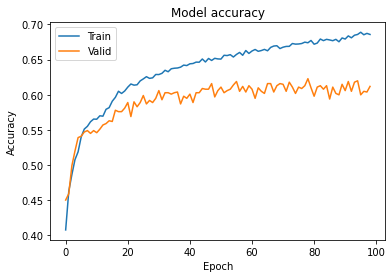

In [94]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [95]:
model.evaluate(test_df, to_categorical(test_lab))

2456/2456 [==============================] - 0s 25us/step


[1.127368462590519, 0.6066775244299675]

In [96]:
dnn_test_probs = model.predict(test_df)
dnn_test_preds_num = np.argmax(dnn_test_probs, axis=1)
dnn_test_preds = [reverse_id_dict[pred] for pred in dnn_test_preds_num]

### Metrics

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

#### Logistic Regression

In [128]:
print("Logistic Regression Classification Report\n")
print(classification_report(test_labels, logreg_test_preds))

Logistic Regression Classification Report

                       precision    recall  f1-score   support

        Cell.membrane       0.63      0.67      0.65       224
            Cytoplasm       0.52      0.42      0.46       424
Endoplasmic.reticulum       0.53      0.51      0.52       162
        Extracellular       0.88      0.90      0.89       377
      Golgi.apparatus       0.37      0.21      0.27        63
     Lysosome/Vacuole       0.30      0.18      0.22        57
        Mitochondrion       0.70      0.68      0.69       299
              Nucleus       0.66      0.81      0.73       675
           Peroxisome       0.43      0.11      0.17        28
              Plastid       0.72      0.72      0.72       147

            micro avg       0.66      0.66      0.66      2456
            macro avg       0.57      0.52      0.53      2456
         weighted avg       0.65      0.66      0.65      2456



In [59]:
logreg_cm = confusion_matrix(test_labels, logreg_test_preds)

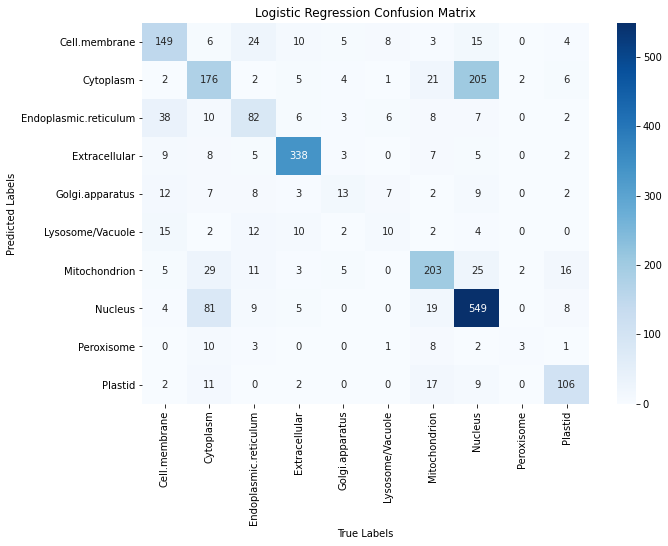

In [116]:
df_cm = pd.DataFrame(logreg_cm, index=sorted(id_dict.keys()), columns=sorted(id_dict.keys()))
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Logistic Regression Confusion Matrix")
plt.show(fig)

#### Keras DNN

In [127]:
print("Keras DNN Classification Report\n")
print(classification_report(test_labels, dnn_test_preds))

Keras DNN Classification Report

                       precision    recall  f1-score   support

        Cell.membrane       0.48      0.75      0.58       224
            Cytoplasm       0.53      0.43      0.48       424
Endoplasmic.reticulum       0.35      0.23      0.28       162
        Extracellular       0.81      0.91      0.86       377
      Golgi.apparatus       0.00      0.00      0.00        63
     Lysosome/Vacuole       0.00      0.00      0.00        57
        Mitochondrion       0.51      0.75      0.60       299
              Nucleus       0.68      0.79      0.73       675
           Peroxisome       0.00      0.00      0.00        28
              Plastid       0.00      0.00      0.00       147

            micro avg       0.61      0.61      0.61      2456
            macro avg       0.34      0.39      0.35      2456
         weighted avg       0.53      0.61      0.56      2456



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [118]:
dnn_cm = confusion_matrix(test_labels, dnn_test_preds)

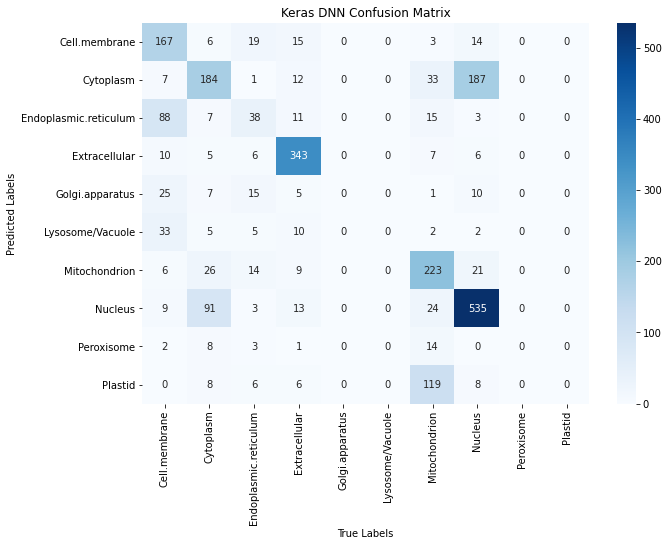

In [125]:
df_cm = pd.DataFrame(dnn_cm, index=sorted(id_dict.keys()), columns=sorted(id_dict.keys()))
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Keras DNN Confusion Matrix")
plt.show(fig)

In [124]:
df_cm

dict_keys(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum', 'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus', 'Peroxisome', 'Plastid', 'Extracellular'])